# Computing Shapley values for a torch model

This notebook illustrates how to wrap a `torch.nn.Module` model using [skorch](https://skorch.readthedocs.io/en/stable/) and use it with pyDVL to compute Shapley values. The model is a simple convolutional neural network (CNN) that classifies handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

The notebook follows almost verbatim the first few steps of the notebook on MSR Banzhaf.

## Setup

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from __future__ import annotations

%matplotlib inline

import os
import random
import warnings

import matplotlib.pyplot as plt
import torch
from support.common import filecache
from support.datasets import load_digits_dataset

from pydvl.reporting.plots import plot_result_errors

warnings.filterwarnings("ignore")

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_state = 36

n_jobs = 6
n_epochs = 24
batch_size = 128
random.seed(random_state)
torch.manual_seed(random_state);

## The dataset

The data consists of ~1800 grayscale images of 8x8 pixels with 16 shades of gray. These images contain handwritten digits from 0 to 9. The helper function `load_digits_dataset()` downloads and prepares it for usage returning two [Datasets][pydvl.valuation.dataset.Dataset].

In [2]:
train, test = load_digits_dataset(
    train_size=0.7, random_state=random_state, device=device
)

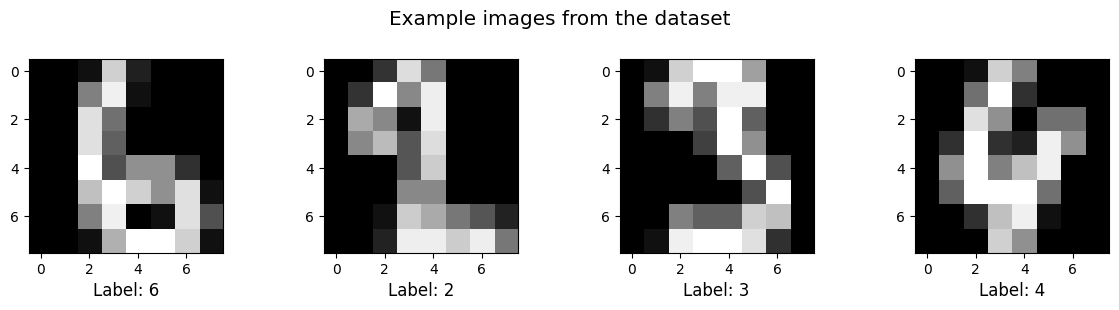

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    ax = axes[i]
    ax.imshow(train.data().cpu().x[i].reshape((8, 8)), cmap="gray")
    ax.set_xlabel(f"Label: {train.data().y[i]}")
plt.suptitle("Example images from the dataset")
plt.tight_layout()
plt.show();

## Creating the utility using a skorch model

Now we can calculate the contribution of each training sample to the model performance. We use a simple CNN written in torch wrapped as a skorch model. Something to keep in mind is to pass `torch_load_kwargs={"weights_only": False}` to the `NeuralNetClassifier` constructor, otherwise the model will fail to pickle and parallelization won't work.

In [4]:
# Reduce computation time in CI
if is_CI:
    train = train[:10]
    test = test[:10]
    n_jobs = 1
    n_epochs = 1
    batch_size = 1
    filecache = lambda x: lambda y: y  # passthrough

In [5]:
from skorch import NeuralNetClassifier
from support.banzhaf import SimpleCNN

model = NeuralNetClassifier(
    SimpleCNN,
    criterion=torch.nn.CrossEntropyLoss,
    lr=0.01,
    max_epochs=n_epochs,
    batch_size=batch_size,
    train_split=None,
    optimizer=torch.optim.Adam,
    device=device,
    verbose=False,
    torch_load_kwargs={"weights_only": False},
)
model.fit(*train.data());

In [6]:
print(f"Training accuracy: {model.score(*train.data().cpu()):.3f}")
print(f"Test accuracy: {model.score(*test.data().cpu()):.3f}")

Training accuracy: 0.984
Test accuracy: 0.971


As with every model-based valuation method, we need a scoring function to measure the performance of the model over the test set. We will use accuracy, but it can be anything, e.g. $R^2$, using strings from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html), passed to [SkorchSupervisedScorer][pydvl.valuation.scorers.skorch.SkorchSupervisedScorer].

We group our skorch model and the scoring function into an instance of [ModelUtility][pydvl.valuation.utility.ModelUtility].

In [7]:
from pydvl.valuation.scorers import SkorchSupervisedScorer
from pydvl.valuation.stopping import MinUpdates
from pydvl.valuation.utility import ModelUtility

accuracy_over_test_set = SkorchSupervisedScorer(
    model, test_data=test, default=0.0, range=(0, 1)
)

utility = ModelUtility(model=model, scorer=accuracy_over_test_set)

In order to compute Shapley values, we use [TMCSShapleyValuation][pydvl.valuation.methods.shapley.TMCSShapleyValuation].

We choose to stop computation using the [MinUpdates][pydvl.valuation.stopping.MinUpdates] stopping criterion, which terminates after a fixed number of value updates.

We also define a relative [TruncationPolicy][pydvl.valuation.samplers.truncation.TruncationPolicy], which is a policy used to early-stop computation of marginal values in permutations, once the utility is close to the total utility. This is a heuristic to speed up computation introduced in the Data-Shapley paper called Truncated Monte Carlo Shapley. Note how we tell it to wait until at least 30% of every permutation has been processed in order to start evaluation. This is to ensure that noise doesn't stop the computation too early.

In [8]:
from pydvl.valuation.samplers import RelativeTruncation

truncation = RelativeTruncation(rtol=0.05, burn_in_fraction=0.3)
stopping = MinUpdates(100)

In [9]:
if is_CI:
    from pydvl.valuation.stopping import MaxChecks

    stopping = MaxChecks(1)  # Stop after 1 utility evaluation

We now instantiate and fit the valuation. Note how parallelization is just a matter of using joblib's context manager `parallel_config` in order to set the number of jobs.

In [ ]:
from joblib import parallel_config

from pydvl.valuation.methods import TMCShapleyValuation

valuation = TMCShapleyValuation(utility, truncation=truncation, is_done=stopping, progress=True)

# filecache is a very simple wrapper not intended for production code
cached_fit = filecache("shapley_skorch_result.pkl")(lambda d: valuation.fit(d).result)
with parallel_config(n_jobs=n_jobs):
    result = cached_fit(train)

Truncated Monte Carlo Shapley-ModelUtility-PermutationSampler(batch_size=1)-MinUpdates(n_updates=100): 0.00%| …

The results object is of type [ValuationResult][pydvl.valuation.result.ValuationResult], and contains values, variances and number of updates of the Monte Carlo estimates. It can be indexed, sliced and copied in natural ways, as we illustrate below.

Let us plot the results. In the next cell we will take the 10 images with the lowest score and plot their values with 95% Normal confidence intervals.

In [ ]:
bottom = result.sort()[:10]
plot_result_errors(
    bottom,
    level=0.05,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show();